# Ejercicio 2: Face Detection

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar desde cero una solucion para detección de caras. Se proveen datos de entrenamiento y es necesario implementar su propio algoritmo de sliding window para entrenar un clasificador. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



##### Imports necesarios

In [1]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import *
import sys
import math
#from google.colab.patches import cv2_imshow
from image_utils import *
#from imutils.object_detection import non_max_suppression

### Funciones Provistas



#### Feature Extractors 

Para resolver el ejercicio van a tener que implementar las funciones `extract_hog_features` y `extract_lbp_features`

In [2]:
class FeatureExtractors(Enum):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method, img):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(img)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(img)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(img)	
	
	return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
	resized_image = cv2.resize(img,resize_size)
	image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
	return image_representation
  
def extract_lbp_features(img):
  return []

def extract_hog_features(img):
  return []


#### Data loader

In [3]:
def load_training_data(training_positive_dir,trainign_negative_dir, feature_extractor=FeatureExtractors.MiniImage):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #comment this line for loading all data
    positive_img_files = positive_img_files[:100]
    negative_img_files = negative_img_files[:200]

    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in positive_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in negative_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*'))
    val_images = []
    for img_file in validation_image_files:
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)

    return val_images 

##### Sliding Window


In [4]:
def sliding_window(image, window_size, scale, stride):
    [image_rows, image_cols] = image.shape
    window_rows = window_size[0]
    window_cols = window_size[1]

    patches = np.zeros((window_rows, window_cols,5))
    bbox_locations = np.zeros((5,4))
    r = np.random.randint(0,image_rows-window_rows,5) # Sample top left position
    c = np.random.randint(0,image_cols-window_cols,5)
    for i in range(0,5):
        patches[:,:,i] = image[r[i]:r[i]+window_rows, c[i]:c[i]+window_cols]
        bbox_locations[i,:] = [r[i],c[i],window_rows,window_cols] # top-left y,x, height, width


    return patches, bbox_locations

##### Metodos Auxiliares


In [20]:
def show_image_with_bbox(image,bboxes,draw_GT=True):
    image_to_draw = image
    GT = [82,91,166,175]
    if draw_GT:
        cv2.rectangle(image, (GT[0],GT[1]), (GT[2],GT[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            #new_image = image
            cv2.rectangle(image_to_draw, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(image_to_draw[...,::-1])
    plt.axis('off')
    plt.show()
    #cv2.imshow('image',image)
    #cv2.waitKey(0) #wait for any key
    #cv2.destroyAllWindows()

### Ubicación de los datos ###

In [6]:
data_dir='./data'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'non_faces_images','neg_cropped_img')
validation_faces_dir = os.path.join(face_detection_dir,'val_face_detection_images')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

## Entrenar Modelo y Face Detection


### Cargar Datos de Entrenamiento ###

In [6]:
#Modify data_loader.py to load more training data
training_data, trainig_labels = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.MiniImage)
# You can save traninig_data and labels on nunmpy files to avoid processing data every time. 

##Loading 100 positive face images
##Loading 200 negative face images


### Load Validation Data ###

In [7]:
validation_data = load_validation_data(validation_faces_dir)

### Entrenar un clasificador utilizando los datos de entrenamiento ## 
1. Una vez los datos de entrenamiento han sido cargados es necesario entrenar su propio clasificador 
2. Como solución inicial se utiliza un clasificador KNN pero para tener mejores resultados es posible entrenar un SVM
3. Train your own classifier and save it on 'face_detector' file.Liblinear is suggested sample code for liblinear can be seen in './liblinear-2.30/python/README' file, good starting parameters for the classfier are '-s 2 -B 1'. 

In [9]:
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [10]:
knn_classifier.fit(training_data,trainig_labels)

KNeighborsClassifier(n_neighbors=3)

#### Guardar el modelo entrenado ##

In [11]:
pickle.dump(knn_classifier,open('./face_detector', 'wb'))

#### Cargar el Modelo entrenado 

In [12]:
classifier = pickle.load(open('./face_detector','rb'))

### Do the sliding window and Visualize Results ###
1. In this part you need to perform the sliding window and score the probabilty of each patch of being a face and select the highest probability patches. 
    1a. Program you own sliding window in 'img_utils' file.
    1b. Extract Features and classify each patch with your own classifier. 
2. Do non-max suppression to select the target face patch with best probability (This is provided in 'img_utils')
3. Visualize Detection with Ground Throuth Bounding Box ('Code for Visualization is Provided')

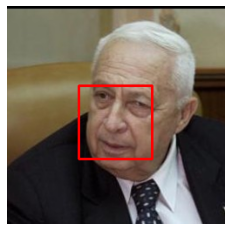

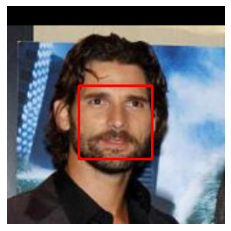

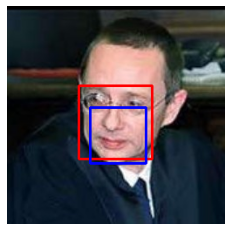

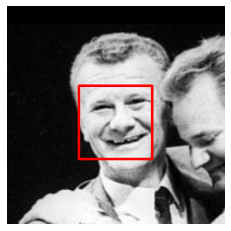

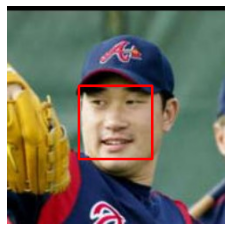

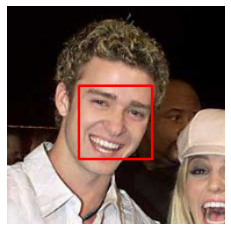

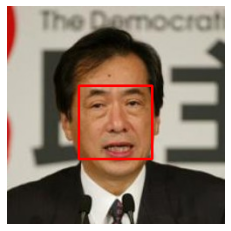

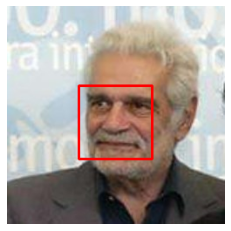

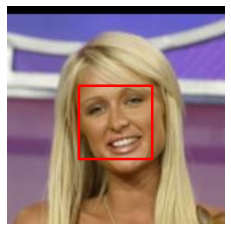

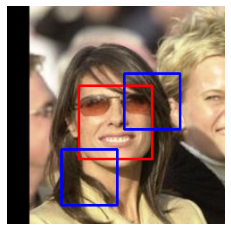

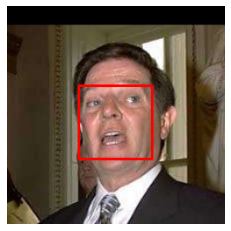

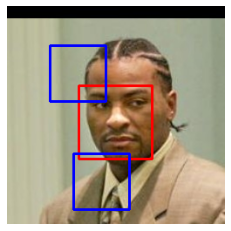

In [13]:
window_size = [64, 64]
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data = load_validation_data(validation_faces_dir)
for img in validation_data:
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,1,1)

    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get prediction label for each sliding window patch
    labels = classifier.predict(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    face_bboxes = bbox_locations[face_probabilities>threshold_p]
    face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
    # Do non max suppression and select strongest probability box
    [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites)
    show_image_with_bbox(img, selected_bbox)


### Evaluate Detector ###

In [7]:
def evaluate_detector(bboxes, positive_probabilites):
    
    true_positives_number = np.zeros((100))
    actual_positives = np.zeros((100))
    predicted_positives = np.zeros((100))
    overlap_threshold = 0.5

    for i in np.arange(0,1,0.01):
        probability_threshold = i
        positive_bboxes = bboxes[positive_probabilites>=probability_threshold]
        positive_bboxes_prob = positive_probabilites[positive_probabilites>=probability_threshold]
        idx = int(np.round(i*100))
        if len(positive_bboxes) > 0:
            [selected_bboxes, selected_scores] = non_max_suppression(positive_bboxes, positive_bboxes_prob,0.3)
            ratio = []
            for selected_bbox in selected_bboxes:
                ratio.append(bb_intersection_over_union(selected_bbox, [82,91,84,84]));                                   
            
            ratio = np.asarray(ratio)
            positive_number = sum(ratio>=0.5); 
            
            true_positives_number[idx] = positive_number>=1;
            actual_positives[idx] = 1
            predicted_positives[idx] = len(ratio)

        else:
            true_positives_number[idx] = 0;
            actual_positives[idx] = 1
            predicted_positives[idx] = 0

    return [true_positives_number, actual_positives, predicted_positives]

In [15]:
total_true_positives = []
total_real_positives = []
total_true_prediction = []
window_size = [64, 64]
score_threshold = 0.5
sum_boxes=0
idx=0
for subject_folder in sorted(glob(validation_raw_faces_dir + '/*')):
    for img in sorted(glob(subject_folder + '/*.jpg')):
        idx+=1
        gray_image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
        ## You need to extract features for every patch (same features you used for training the classifier)
        patches_feature_representation = []
        for i in range(patches.shape[2]):
            patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
            patches_feature_representation.append(patch_representation)
        patches_feature_representation = np.asarray(patches_feature_representation)
        ## Get score for each sliding window patch
        scores = classifier.predict_proba(patches_feature_representation)
        ## Positive Face Probabilities
        face_probabilities = scores[:,1]
        ## Filter boxes by probability or score KNN probability > 0.5 or SVM score > 0
        [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities );
        
        total_true_positives.append(detected_true_positives)
        total_real_positives.append(image_real_positives)
        total_true_prediction.append(detected_faces)

total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_true_prediction = np.asarray(total_true_prediction)


In [16]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

(0.0, 1.1)

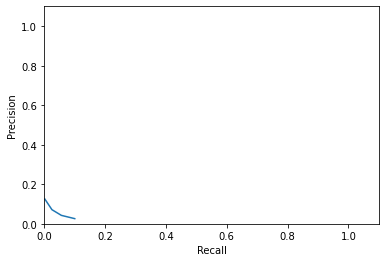

In [17]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [18]:
ap = interpolated_average_precision(recall,precision)

In [19]:
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.000323]


## Ejercicio Resuelto

### Imports

In [1]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import *
import sys
import math
from image_utils import *
from skimage.feature import local_binary_pattern, hog
from sklearn.svm import SVC

### Feature Extractors

In [2]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3

def extract_features(method, img):
    '''Switch between Feature extraction Methods'''

    image_representation = []

    if method == FeatureExtractors.MiniImage:
        image_representation = extract_mini_image_features(img)
    elif method == FeatureExtractors.HOG:
        image_representation = extract_hog_features(img)
    elif method == FeatureExtractors.LBP:
        image_representation = extract_lbp_features(img)

    return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
    resized_image = cv2.resize(img,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation


def extract_lbp_features(img, radius=3, method='uniform'):
    #https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-local-binary-pattern-py
    n_points = 8 * radius
    return local_binary_pattern(img, P=n_points, R=radius, method=method)
    

def extract_hog_features(img,orientations=8,pixels_per_cell=(16, 16),cells_per_block=(1, 1)):
    #https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
    return hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)


### Load Training & Validation Data

In [3]:
def load_training_data(training_positive_dir,trainign_negative_dir, feature_extractor=FeatureExtractors.MiniImage):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #comment this line for loading all data
    positive_img_files = positive_img_files[:100]
    negative_img_files = negative_img_files[:200]

    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in positive_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in negative_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*'))
    val_images = []
    for img_file in validation_image_files:
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)

    return val_images 

In [19]:
data_dir='./data'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'non_faces_images','neg_cropped_img')
validation_faces_dir = os.path.join(face_detection_dir,'val_face_detection_images')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

In [23]:
training_array = []

#MiniImage
training_data_mi, trainig_labels_mi = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.MiniImage)
training_array.append([training_data_mi,trainig_labels_mi, 'miniImage'])
#Hog
training_data_hog, trainig_labels_hog = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.HOG)
training_array.append([training_data_hog,trainig_labels_hog, 'hog'])
#LBP
training_data_lbp, trainig_labels_lbp = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.LBP)
## Solución a problemas con dimensiones en training_data para LBP 
#  https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
nsamples, nx, ny = training_data_lbp.shape
training_data_lbp = training_data_lbp.reshape((nsamples,nx*ny))
training_array.append([training_data_lbp,trainig_labels_lbp,'lbp'])

validation_data = load_validation_data(validation_faces_dir) 

##Loading 100 positive face images
##Loading 200 negative face images
##Loading 100 positive face images
##Loading 200 negative face images
##Loading 100 positive face images
##Loading 200 negative face images


### Sliding window

In [18]:
def show_image_with_bbox(image,bboxes,draw_GT=True):
    image_to_draw = image
    GT = [82,91,166,175]
    if draw_GT:
        cv2.rectangle(image, (GT[0],GT[1]), (GT[2],GT[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            #new_image = image
            cv2.rectangle(image_to_draw, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(image_to_draw[...,::-1])
    plt.axis('off')
    plt.show()

In [17]:
def sliding_window(image, window_size, scale, stride):
    new_image_bbo = image
    [image_rows, image_cols] = image.shape
    window_rows = window_size[0]
    window_cols = window_size[1]
    
    total_patches = math.ceil(image_rows/stride * image_cols/stride)
    patches = np.zeros((window_rows, window_cols,total_patches))
    bbox_locations = np.zeros((total_patches,4))
    
    r_pos = list(range(0, image_rows-window_rows, stride))
    c_pos = list(range(0, image_cols-window_cols, stride))
    
    k=0

    for r in r_pos:
        for c in c_pos:
            patches[:,:,k] = image[r:r+window_rows, c:c+window_cols]
            bbox_locations[k,:] = [r,c,window_rows,window_cols]
            k=k+1
            #print(k)
            #show_image_with_bbox(new_image_bbo, bbox_locations)
    
    return patches, bbox_locations

### Train and Load Classifier

In [8]:
#KNN
def train_knn_classifier(training_data, training_labels,extractor,n=3):
    knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    knn_classifier.fit(training_data,trainig_labels)
    detector_name='./face_detector_knn_'+n+'_'+extractor
    pickle.dump(knn_classifier,open(detector_name, 'wb'))
    trained_knn_classifier = pickle.load(open(detector_name,'rb'))
    return trained_knn_classifier

#SVM
def train_svm_classifier(C, kernel, training_data, training_labels, probability=True):
    svm_classifier = SVC(C=C, kernel=kernel, probability=probability)
    trained_svm_classifier = svm_classifier.fit(training_data, training_labels)
    """detector_name='./face_detector_svm_'+str(C)+'_'+str(kernel)+'_'+extractor
    pickle.dump(svm_classifier, open(detector_name, 'wb'))
    trained_svm_classifier = pickle.load(open(detector_name,'rb'))"""
    return trained_svm_classifier


In [9]:
def load_detectors(training_data, training_labels):
    detectors = []
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    C = [0.01, 0.1, 0.5, 1, 2, 5]
    for training_tuple in training_array:
        for c in C: 
            for kernel in kernels:
                detectors.append(train_svm_classifier(C=c, kernel=kernel, training_data=training_data, training_labels=training_labels,extractor=training_tuple[2]))
    return detectors


### Apply and Evaluate Detector 

In [21]:
classifiers = {}

for training_tuple in training_array:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            for c in [0.01, 0.1, 0.5, 1, 2, 5]:
                print('Training for '+'kernel:'+kernel+' c:'+str(c)+' extractor:'+training_tuple[2]+' - Started')
                classifier = train_svm_classifier(c, kernel, training_data=training_tuple[0], training_labels=training_tuple[1])
                classifiers[''+kernel+''+str(c)+''+training_tuple[2]+''] = classifier
                print('Training for '+'kernel:'+kernel+' c:'+str(c)+' extractor:'+training_tuple[2]+' - Finished')


Training for kernel:linear c:0.01 extractor:miniImage - Started
Training for kernel:linear c:0.01 extractor:miniImage - Finished
Training for kernel:linear c:0.1 extractor:miniImage - Started
Training for kernel:linear c:0.1 extractor:miniImage - Finished
Training for kernel:linear c:0.5 extractor:miniImage - Started
Training for kernel:linear c:0.5 extractor:miniImage - Finished
Training for kernel:linear c:1 extractor:miniImage - Started
Training for kernel:linear c:1 extractor:miniImage - Finished
Training for kernel:linear c:2 extractor:miniImage - Started
Training for kernel:linear c:2 extractor:miniImage - Finished
Training for kernel:linear c:5 extractor:miniImage - Started
Training for kernel:linear c:5 extractor:miniImage - Finished
Training for kernel:poly c:0.01 extractor:miniImage - Started
Training for kernel:poly c:0.01 extractor:miniImage - Finished
Training for kernel:poly c:0.1 extractor:miniImage - Started
Training for kernel:poly c:0.1 extractor:miniImage - Finished


In [19]:
"""window_size = [64, 64]
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5



for img in validation_data:
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,1,32)

    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation_mi = []
    patches_feature_representation_hog = []
    patches_feature_representation_lbp = []
    for i in range(patches.shape[2]):
        
        patches_feature_representation_mi.append(extract_features(FeatureExtractors.MiniImage, patches[:,:,i]))
        patches_feature_representation_hog.append(extract_features(FeatureExtractors.HOG, patches[:,:,i]))
        
        patches_feature_representation_lbp.append(extract_features(FeatureExtractors.LBP, patches[:,:,i]))

    patches_feature_representation_mi = np.asarray(patches_feature_representation_mi)
    patches_feature_representation_hog = np.asarray(patches_feature_representation_hog)
    patches_feature_representation_lbp = np.asarray(patches_feature_representation_lbp)

    for training_tuple in training_array:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            for c in [0.01, 0.1, 0.5, 1, 2, 5]:
                classifier = classifiers[''+kernel+''+str(c)+''+training_tuple[2]+'']
                ## Get prediction label and score for each sliding window patch 
                print('c:',c,', kernel: ',kernel,', feature_extraction: ',training_tuple[2])
                if training_tuple[2] == 'miniImage':
                    labels = classifier.predict(patches_feature_representation_mi)
                    scores = classifier.predict_proba(patches_feature_representation_mi) 
                elif training_tuple[2] == 'hog':
                    labels = classifier.predict(patches_feature_representation_hog)
                    scores = classifier.predict_proba(patches_feature_representation_hog)
                else:
                    if len(patches_feature_representation_lbp.shape) == 3:
                        nsamples, nx, ny = patches_feature_representation_lbp.shape
                        patches_feature_representation_lbp = patches_feature_representation_lbp.reshape((nsamples,nx*ny))
                    labels = classifier.predict(patches_feature_representation_lbp)
                    scores = classifier.predict_proba(patches_feature_representation_lbp)
                ## Positive Face Probabilities
                face_probabilities = scores[:,1]
                face_bboxes = bbox_locations[face_probabilities>threshold_p]
                face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
                ## Do non max suppression and select strongest probability box
                [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
                
                %matplotlib inline
                show_image_with_bbox(img, selected_bbox)
"""
    """
    ## Load detectors
    svm_mi_detectors = load_detectors(training_data_mi, trainig_labels_mi)
    svm_hog_detectors = load_detectors(training_data_hog, trainig_labels_hog)
    svm_lbp_detectors = load_detectors(training_data_lbp, trainig_labels_lbp)
    """
    """
    ## Get prediction label for each sliding window patch
    labels = classifier.predict(patches_feature_representation)
    
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    face_bboxes = bbox_locations[face_probabilities>threshold_p]
    face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
    
    ## Do non max suppression and select strongest probability box
    [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
    show_image_with_bbox(img, selected_bbox)"""

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
c: 0.01 , kernel:  linear , feature_extraction:  miniImage
c: 0.1 , kernel:  linear , feature_extraction:  miniImage
c: 0.5 , kernel:  linear , feature_extraction:  miniImage
c: 1 , kernel:  linear , feature_extraction:  miniImage
c: 2 , kernel:  linear , feature_extraction:  miniImage
c: 5 , kernel:  linear , feature_extraction:  miniImage
c: 0.01 , kernel:  poly , feature_extraction:  miniImage
c: 0.1 , kernel:  poly , feature_extraction:  miniImage
c: 0.5 , kernel:  poly , feature_extraction:  miniImage
c: 1 , kernel:  poly , feature_extraction:  miniImage
c: 2 , kernel:  poly , feature_extraction:  miniImage
c: 5 , kernel:  poly , feature_extraction:  miniImage
c: 0.01 , kernel:  rbf , feature_extraction:  miniImage
c: 0.1 , kernel:  rbf , feature_extraction:  miniImage
c: 0.5 , kernel:  rbf , feature_extraction:  miniImage
c: 1 , kernel:  rbf , feature_extraction:  miniImage
c: 2 , k

KeyboardInterrupt: 

In [11]:
def evaluate_w_specific_extractor(extractor):
    
    
    window_size = [64, 64]
    score_threshold = 0.5
    sum_boxes=0
    idx=0
    classifiers_results = []

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)

    
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
                for c in [0.01, 0.1, 0.5, 1, 2, 5]:

                    total_true_positives = []
                    total_real_positives = []
                    total_true_prediction = []
                    classifier = classifiers[''+kernel+''+str(c)+''+extractor+'']
                    
                    for subject_folder in sorted(glob(validation_raw_faces_dir + '/*')):
                        for img in sorted(glob(subject_folder + '/*.jpg')):
                            idx+=1
                            gray_image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
                            patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
                            ## You need to extract features for every patch (same features you used for training the classifier)
                            patches_feature_representation = []
                            if extractor == 'hog':
                                actual_extractor = FeatureExtractors.HOG
                            elif extractor == 'lbp':
                                actual_extractor = FeatureExtractors.LBP
                            else:
                                actual_extractor = FeatureExtractors.MiniImage
                            
                            for i in range(patches.shape[2]):
                                patch_representation = extract_features(actual_extractor, patches[:,:,i])
                                patches_feature_representation.append(patch_representation)
                            patches_feature_representation = np.asarray(patches_feature_representation)
                            ## Get score for each sliding window patch
                            if len(patches_feature_representation.shape) == 3:
                                nsamples, nx, ny = patches_feature_representation.shape
                                patches_feature_representation = patches_feature_representation.reshape((nsamples,nx*ny))
                            scores = classifier.predict_proba(patches_feature_representation)
                            ## Positive Face Probabilities
                            face_probabilities = scores[:,1]
                            ## Filter boxes by probability or score KNN probability > 0.5 or SVM score > 0
                            [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities );
                            
                            total_true_positives.append(detected_true_positives)
                            total_real_positives.append(image_real_positives)
                            total_true_prediction.append(detected_faces)

                    total_true_positives = np.asarray(total_true_positives)
                    total_real_positives = np.asarray(total_real_positives)
                    total_true_prediction = np.asarray(total_true_prediction)
                    precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)
                    plt.plot(recall, precision)
                    
                    ap = interpolated_average_precision(recall,precision)
                    classifiers_results.append([(''+kernel+''+str(c)+''+extractor+''), precision, recall, ap])
                    print('Detection Average for '+''+kernel+' '+str(c)+' '+extractor+' ' + ' Precision is {}'.format(ap))
    return classifiers_results
                    

Detection Average for linear 0.01 miniImage  Precision is [0.00645537]
Detection Average for linear 0.1 miniImage  Precision is [0.00651861]
Detection Average for linear 0.5 miniImage  Precision is [0.00762827]
Detection Average for linear 1 miniImage  Precision is [0.006388]
Detection Average for linear 2 miniImage  Precision is [0.00547748]
Detection Average for linear 5 miniImage  Precision is [0.00787566]
Detection Average for poly 0.01 miniImage  Precision is [0.12710979]
Detection Average for poly 0.1 miniImage  Precision is [0.1430503]
Detection Average for poly 0.5 miniImage  Precision is [0.14967419]
Detection Average for poly 1 miniImage  Precision is [0.10339893]
Detection Average for poly 2 miniImage  Precision is [0.09267289]
Detection Average for poly 5 miniImage  Precision is [0.05994155]
Detection Average for rbf 0.01 miniImage  Precision is [0.20167644]
Detection Average for rbf 0.1 miniImage  Precision is [0.19651163]
Detection Average for rbf 0.5 miniImage  Precision

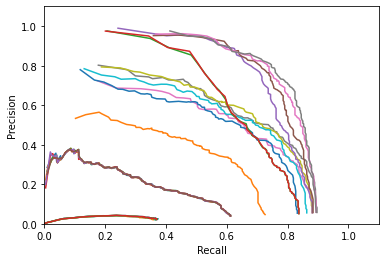

In [29]:
mini_image_results = evaluate_w_specific_extractor('miniImage')

Detection Average for linear 0.01 hog  Precision is [0.01514517]
Detection Average for linear 0.1 hog  Precision is [0.01147626]
Detection Average for linear 0.5 hog  Precision is [0.03632368]
Detection Average for linear 1 hog  Precision is [0.06433491]
Detection Average for linear 2 hog  Precision is [0.05315615]
Detection Average for linear 5 hog  Precision is [0.03828118]
Detection Average for poly 0.01 hog  Precision is [0.00791344]
Detection Average for poly 0.1 hog  Precision is [0.02278374]
Detection Average for poly 0.5 hog  Precision is [0.0248062]
Detection Average for poly 1 hog  Precision is [0.0248062]
Detection Average for poly 2 hog  Precision is [0.02298382]
Detection Average for poly 5 hog  Precision is [0.025323]
Detection Average for rbf 0.01 hog  Precision is [0.04766617]
Detection Average for rbf 0.1 hog  Precision is [0.04118571]
Detection Average for rbf 0.5 hog  Precision is [0.01503406]
Detection Average for rbf 1 hog  Precision is [0.01902748]
Detection Avera

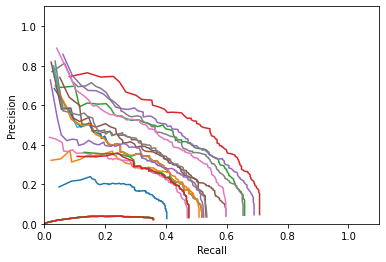

In [24]:
hog_results = evaluate_w_specific_extractor('hog')

Detection Average for linear 0.01 lbp  Precision is [0.01610018]
Detection Average for linear 0.1 lbp  Precision is [0.0126615]
Detection Average for linear 0.5 lbp  Precision is [0.01406833]
Detection Average for linear 1 lbp  Precision is [0.01406833]
Detection Average for linear 2 lbp  Precision is [0.01406833]
Detection Average for linear 5 lbp  Precision is [0.0092285]
e:\Facultad\Computer Vision\cv-um-2021\trabajo-final\evaluation.py:43: RuntimeWarning: invalid value encountered in true_divide
  precision = np.divide(summed_true_positives,summed_predicted_positives)
Detection Average for poly 0.01 lbp  Precision is [0.0067508]
Detection Average for poly 0.1 lbp  Precision is [0.01550388]
Detection Average for poly 0.5 lbp  Precision is [0.01550388]
Detection Average for poly 1 lbp  Precision is [0.01550388]
Detection Average for poly 2 lbp  Precision is [0.01550388]
Detection Average for poly 5 lbp  Precision is [0.00516796]
Detection Average for rbf 0.01 lbp  Precision is [0.016

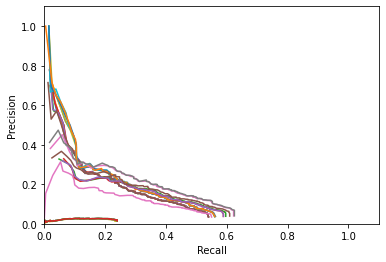

In [22]:
lbp_results = evaluate_w_specific_extractor('lbp')

In [30]:
mini_image_results = sorted(mini_image_results, key=lambda x: x[3], reverse=True)
hog_results = sorted(hog_results, key=lambda x: x[3], reverse=True)
lbp_results = sorted(lbp_results, key=lambda x: x[3], reverse=True)
best_classifiers = sorted([mini_image_results[0], hog_results[0], lbp_results[0]], key=lambda x: x[3], reverse=True)
print(best_classifiers[0][0])
pickle.dump(classifiers[best_classifiers[0][0]],open('./best_face_detector', 'wb'))


rbf5miniImage
